# Checking impact of salinity restoring relative to meltwater perturbation

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from gsw import SA_from_SP, p_from_z

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38805,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:42819,Total threads: 1
Dashboard: /proxy/46271/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45997,


2025-10-21 11:27:43,959 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('rechunk-merge-aa890b3f094382d92f0ef3ba73efb7ec', 10, 5, 2) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: Alias(('rechunk-merge-aa890b3f094382d92f0ef3ba73efb7ec', 10, 5, 2)->('sa_from_sp-rechunk-merge-rechunk-merge-aa890b3f094382d92f0ef3ba73efb7ec', 10, 5, 2))
new run_spec: Alias(('rechunk-merge-aa890b3f094382d92f0ef3ba73efb7ec', 10, 5, 2)->('sa_from_sp-rechunk-merge-aa890b3f094382d92f0ef3ba73efb7ec', 10, 5, 2))
old token: ('0c2762370944dc18', [])
new token: ('1acecc3ea787ad60', [])
old dependencies: {('sa_from_sp-rechunk-me

In [3]:
# Importing the data
db = '/home/272/kc5856/databases/honours_prescribed.db'
session = cc.database.create_session(db)

control = 'panant-01-zstar-ACCESSyr2'
pan01_melt = 'panant-01-zstar-ssp126-prsc-rest'

start_time='2001-01-01'
end_time='2010-12-31'

lat_slice  = slice(-79,-59)

In [4]:
# topography data for plotting:
deptho = cc.querying.getvar(control,'deptho' , session,n=1).sel(yh=lat_slice)
land_mask = np.squeeze(deptho.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
#land_mask_lat = ht.yt_ocean.values
#land_mask_lat[0] = -90

fontsize=15

### Time series of restoring over shelf

In [5]:
# shelf masking:
contour_file = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')
shelf_mask = contour_file['contour_masked_above'].to_numpy()
yh = contour_file['yh'] #slice to match lat_slice
xh = contour_file['xh']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yh', yh.values), ('xh', xh.values)])

In [6]:
# Area
area_old = cc.querying.getvar(control, 'areacello', session,n=1).sel(yh=lat_slice)

# Getting variable
var = cc.querying.getvar(control,'so', session,n=1).isel(time=0,z_l=0).load()

# Correcting area
area = area_old*(var*0 +1)

area = (area*shelf_mask).load()
area_sum = area.sum(dim={'xh','yh'}).load()

In [7]:
# stuff needed for absolute salinity conversion:
z_l = cc.querying.getvar(control,'z_l', session,n=1).load()
geolon = cc.querying.getvar(control,'geolon',session, n=1).sel(yh=lat_slice).load()
geolat = cc.querying.getvar(control,'geolat',session, n=1).sel(yh=lat_slice).load()
depth_tile = -(geolat*0+1)*z_l[0].values
pressure = xr.DataArray(p_from_z(depth_tile,geolat), coords = [('yh', yh[:460].values), ('xh', xh.values)], dims = ['yh', 'xh'], 
                        name = 'pressure', attrs = {'units':'dbar'}) #slice to match lat_slice

In [8]:
SSS_prac = cc.querying.getvar(control, 'so', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
SSS_prac = SSS_prac.sel(time=slice(start_time,end_time)).sel(yh=lat_slice).sel(z_l=0,method='nearest')
# convert units to absolute salinity:
SSS_con = xr.DataArray(SA_from_SP(SSS_prac,pressure,geolon,geolat), coords = [SSS_prac.time, SSS_prac.yh, SSS_prac.xh], 
                       dims = ['time','yh', 'xh'], name = 'sea surface salinity', 
                       attrs = {'units':'Absolute Salinity (g/kg)'})

In [9]:
salt_flux_con = cc.querying.getvar(control, 'salt_flux', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)

salt_flux_con = salt_flux_con.sel(time=slice(start_time,end_time)).sel(yh=lat_slice)
salt_flux_con = -salt_flux_con*1000/SSS_con # negative sign makes this a salt -> FW flux conversion
salt_flux_con.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/salt_flux_con_asFWF_prescribed_pan01.nc')

In [10]:
wfo_con = cc.querying.getvar(control, 'wfo', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)

wfo_con = -(wfo_con*SSS_con)/1000 # converting from freshwater flux to salt flux
wfo_con = wfo_con.sel(time=slice(start_time,end_time)).sel(yh=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
wfo_con = wfo_con*1000/SSS_con
wfo_con.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/wfo_salt_con_prescribed_pan01.nc')

In [9]:
restoring_con = cc.querying.getvar(control, 'salt_flux_added', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
restoring_con = restoring_con.sel(time=slice(start_time,end_time)).sel(yh=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
restoring_con = restoring_con*1000/SSS_con
restoring_con.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_con_prescribed_pan01.nc')

In [10]:
# restrict to shelf and integrate over area:
restoring_con = (restoring_con*area).sum('xh').sum('yh')/area_sum
restoring_con = restoring_con.load()

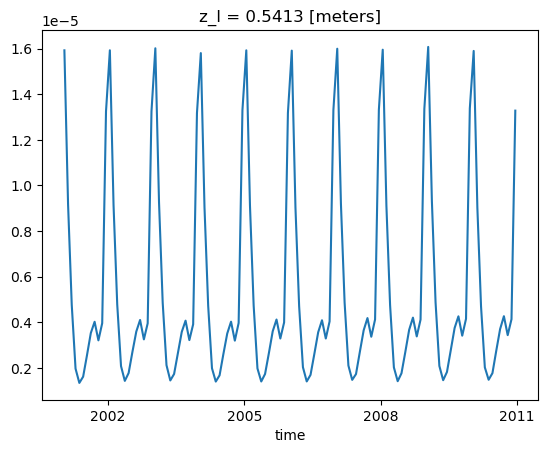

In [11]:
restoring_con.plot()

In [12]:
SSS_prac = cc.querying.getvar(pan01_melt, 'so', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
SSS_prac = SSS_prac.sel(time=slice(start_time,end_time)).sel(yh=lat_slice).sel(z_l=0,method='nearest')
# convert units to absolute salinity:
SSS_melt = xr.DataArray(SA_from_SP(SSS_prac,pressure,geolon,geolat), coords = [SSS_prac.time, SSS_prac.yh, SSS_prac.xh], 
                       dims = ['time','yh', 'xh'], name = 'sea surface salinity', 
                       attrs = {'units':'Absolute Salinity (g/kg)'})

In [13]:
salt_flux_melt = cc.querying.getvar(pan01_melt, 'salt_flux', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)

salt_flux_melt = salt_flux_melt.sel(time=slice(start_time,end_time)).sel(yh=lat_slice)
salt_flux_melt = -salt_flux_melt*1000/SSS_melt # negative sign makes this a salt -> FW flux conversion
salt_flux_melt.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/salt_flux_melt_asFWF_prescribed_pan01.nc')

In [14]:
wfo_melt = cc.querying.getvar(pan01_melt, 'wfo', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)

wfo_melt = -(wfo_melt*SSS_melt)/1000 # converting from freshwater flux to salt flux
wfo_melt = wfo_melt.sel(time=slice(start_time,end_time)).sel(yh=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
wfo_melt = wfo_melt*1000/SSS_melt
wfo_melt.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/wfo_salt_melt_prescribed_pan01.nc')

In [13]:
restoring_melt = cc.querying.getvar(pan01_melt, 'salt_flux_added', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
restoring_melt = restoring_melt.sel(time=slice(start_time,end_time)).sel(yh=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
restoring_melt = restoring_melt*1000/SSS_con #using SSS_con instead of SSS_melt
restoring_melt.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_melt_prescribed_pan01.nc')


In [14]:
# restrict to shelf and integrate over area:
restoring_melt = (restoring_melt*area).sum('xh').sum('yh')/area_sum
restoring_melt = restoring_melt.load()

In [15]:
# compare to runoff:

runoff_con = cc.querying.getvar(control, 'lrunoff', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yh=lat_slice)
# restrict to shelf and integrate over area:
runoff_con = (runoff_con*area).sum('xh').sum('yh')/area_sum
runoff_con = runoff_con.load()

runoff_melt = cc.querying.getvar(pan01_melt, 'lrunoff', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
runoff_melt = runoff_melt.sel(time=slice(start_time,end_time)).sel(yh=lat_slice)
# restrict to shelf and integrate over area:
runoff_melt = (runoff_melt*area).sum('xh').sum('yh')/area_sum
runoff_melt = runoff_melt.load()

Text(0.5, 1.0, 'Runoff and restoring integrated over shelf (new)')

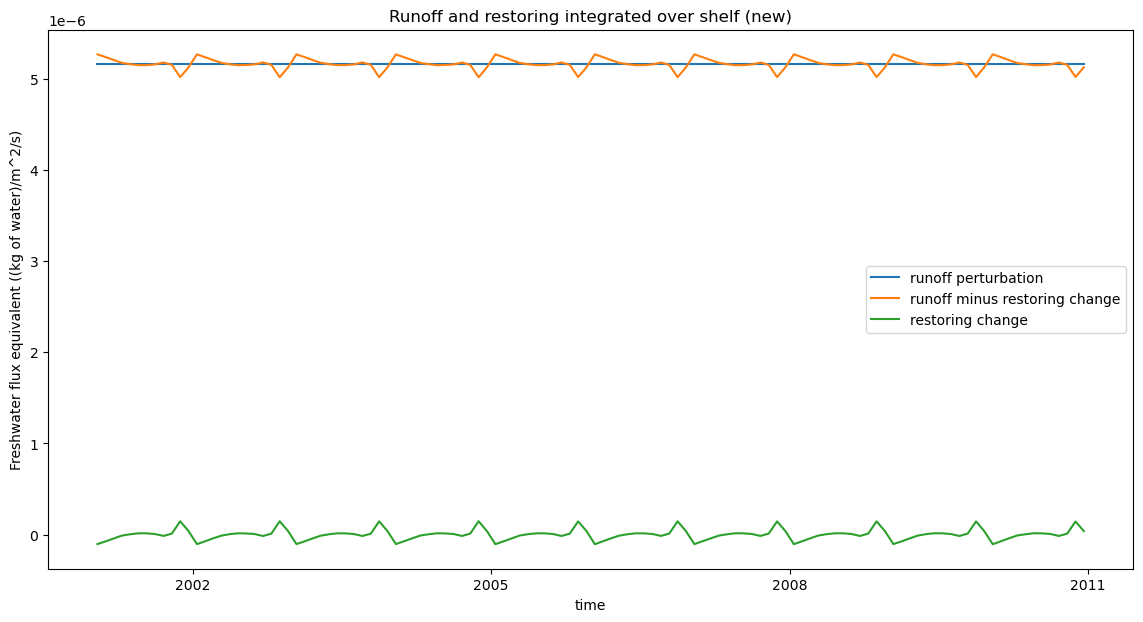

In [16]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))
(runoff_melt - runoff_con).plot(label='runoff perturbation')
((runoff_melt - runoff_con)-(restoring_melt - restoring_con)).plot(label='runoff minus restoring change')
((restoring_melt - restoring_con)).plot(label='restoring change')
plt.legend()
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf (new)')
#plt.ylim(0,2.1e-6)

Text(0.5, 1.0, 'Runoff and restoring integrated over shelf')

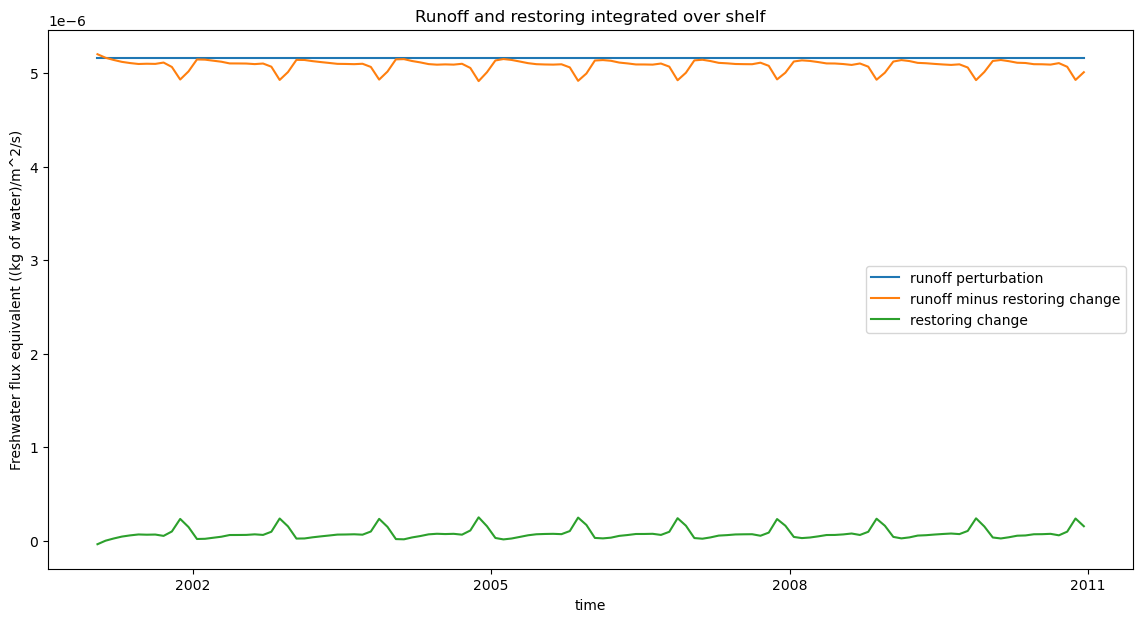

In [14]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))
(runoff_melt - runoff_con).plot(label='runoff perturbation')
((runoff_melt - runoff_con)-(restoring_melt - restoring_con)).plot(label='runoff minus restoring change')
((restoring_melt - restoring_con)).plot(label='restoring change')
plt.legend()
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')
#plt.ylim(0,2.1e-6)

In [17]:
runoff_pert = (runoff_melt - runoff_con)
runoff_minus_restoring_change = (runoff_melt - runoff_con)-(restoring_melt - restoring_con)
restoring_change = (restoring_melt - restoring_con)

In [18]:
runoff_pert.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/runoff_pert_prescribed_pan01.nc')
runoff_minus_restoring_change.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/runoff_minus_restoring_change_prescribed_pan01.nc')
restoring_change.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_change_prescribed_pan01.nc')

# Old plot for reference

Text(0.5, 1.0, 'Runoff and restoring integrated over shelf')

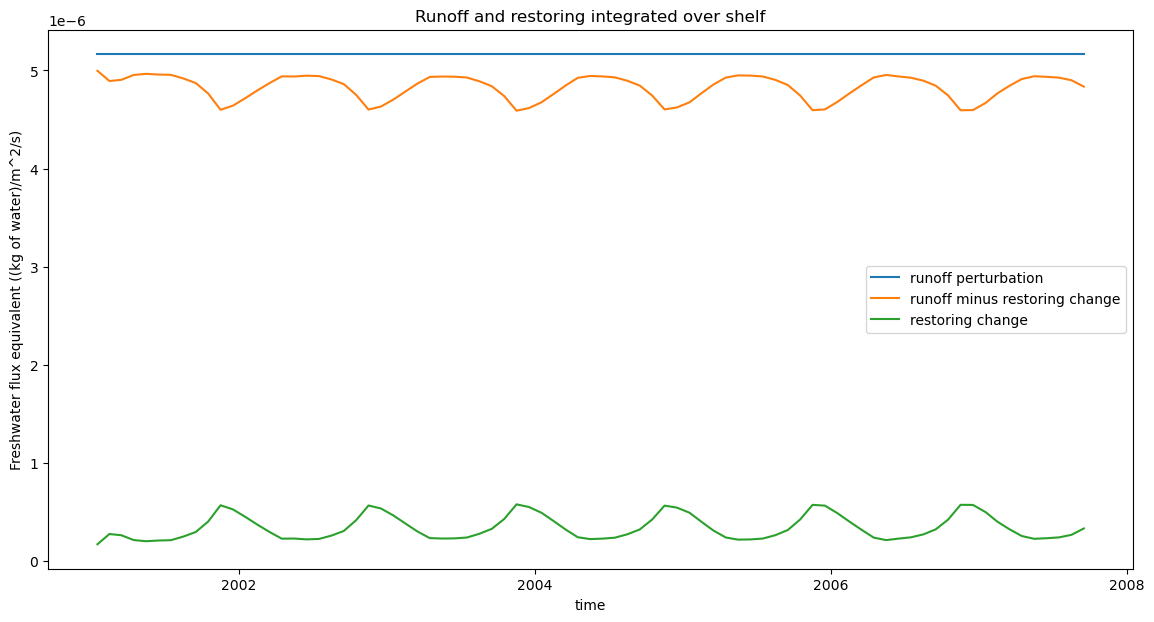

In [12]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))
(runoff_melt - runoff_con).plot(label='runoff perturbation')
((runoff_melt - runoff_con)-(restoring_melt - restoring_con)).plot(label='runoff minus restoring change')
((restoring_melt - restoring_con)).plot(label='restoring change')
plt.legend()
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')
#plt.ylim(0,2.1e-6)

Text(0.5, 1.0, 'Runoff and restoring integrated over shelf')

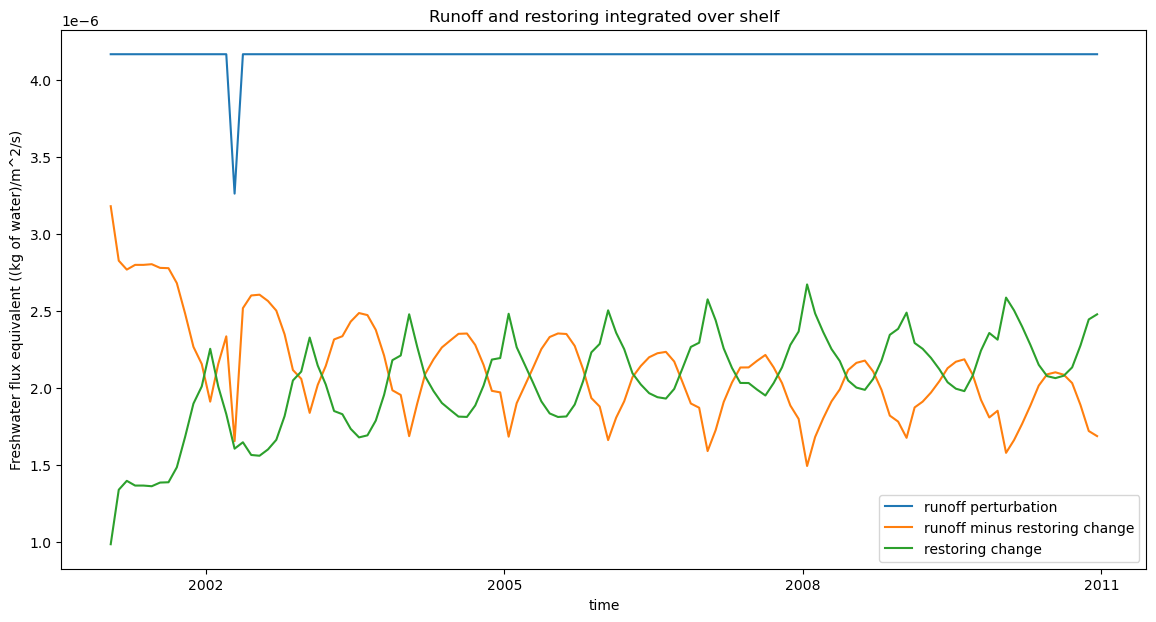

In [11]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))
(runoff_melt - runoff_con).plot(label='runoff perturbation')
((runoff_melt - runoff_con)-(restoring_melt - restoring_con)).plot(label='runoff minus restoring change')
((restoring_melt - restoring_con)).plot(label='restoring change')
plt.legend()
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')
#plt.ylim(0,2.1e-6)